In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gensim
import gensim .corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, Phrases
from gensim.models.ldamodel import LdaModel
from gensim.models.phrases import Phraser

import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_lg


import itertools, operator
import os
import pickle
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

from pprint import pprint
from tqdm import tqdm_notebook as tqdm

In [2]:
debates = pd.read_csv('debate_transcripts.csv')

candidates = ['Warren',
       'Klobuchar', "O'rourke", "O'Rourke", 'Booker', 'Castro', 'Gabbard', 'Patrick',
       'De Blasio', 'Delaney', 'Inslee', 'Ryan','Sanders', 'Bennet', 'Biden', 'Harris', 'Hickenlooper',
       'Gillibrand', 'Buttigieg', 'Yang', 'Swalwell', 'Williamson',
       'Bullock', 'Steyer', 'Bloomberg' ]

withdrawn = ['De Blasio', 'Bullock','Gillibrand','Gravel','Harris', 'Castro','Patrick','Delaney',
             'Hickenlooper','Inslee','Messam','Moulton','Ojeda',"O'rourke","O'Rourke",
             'Sestak','Swalwell','Ryan','Williamson','Gabbard','Bennet','Delaney','Castro','Booker'
            'Bennet','Yang']

debates['candidate'] = debates.apply(lambda x: 1 if x['speakers'] in candidates else 0, axis=1)
debates['withdrawn'] = debates.apply(lambda x: 1 if x['speakers'] in withdrawn else 0, axis=1)

stop_words = {'people','president','senator','thank','going','would','want',
              'right','one','think','american','america','sure',' ','country',
              'govenor','need','congressman','crosstalk','judy','oh','mention',
              'vain','name','sorry','mention','respond','come','say','respond','thing',
             'know','talk','get','look','fact','saying','inaudible','book','glad','decade',
             'fight','mean','way','like','time','states','year'}



In [3]:
nlp = spacy.load("en_core_web_lg")

nlp.Defaults.stop_words.update(stop_words)

for word in STOP_WORDS:
    lexeme = nlp.vocab[word]
    lexeme.is_stop=True

def lemmatize_pipe(doc):
    
    doc = [token.lemma_ for token in doc if token.lemma_ != '-PRON-']
    doc = u' '.join(doc)
    
    return nlp.make_doc(doc)

def remove_stops(doc):
    
    doc = [token.text for token in doc if nlp.vocab[token.text.lower()].is_stop!= True and token.is_punct != True and token.lemma_ not in STOP_WORDS]
    doc = u' '.join(doc)
    
    return nlp.make_doc(doc)

def list_component(doc):
    
    tokens = [token.text for token in doc]
          
    return tokens


def compute_coherence(dictionary, corpus, texts, limit, start=2, step=1):
    
    coherence_values=[]
    model_list=[]
    for num_topic in tqdm(range(start, limit, step)):
        model = LdaModel(corpus=corpus, num_topics=num_topic, id2word=dictionary, random_state=5)
        model_list.append(model)
        coherencemodel=CoherenceModel(model=model, texts=[texts], dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        
    return model_list, coherence_values

def compute_coherence_values(corpus, dictionary, texts, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k,
                                           alpha=a,
                                          chunksize=50,
                                          passes=10,
                                          random_state=5,
                                          eta=b,
                                          per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=[texts], dictionary=dictionary, coherence='c_v')
    
    return lda_model, coherence_model_lda.get_coherence()

def label_point_orig(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.2, point['y']+.1, str(point['val']))

In [4]:
nlp.add_pipe(remove_stops, before='ner')
nlp.add_pipe(lemmatize_pipe, last=True)
nlp.add_pipe(list_component, last=True)

In [5]:
candidates = debates[debates.candidate==1].speakers.unique()
cols = debates.columns
tmp_df = pd.DataFrame()

for candidate in candidates:
    tmp = debates[debates.speakers==candidate]
    arr = np.arange(len(tmp))
    arr = arr + 1
    tmp['n'] = arr
    tmp_df = tmp_df.append(tmp)

debates = pd.merge(debates, tmp_df[['n']], how='left',left_index=True, right_index=True )

In [6]:
trim_responses = debates[debates.candidate==1].dialogue.tolist()
idxs = debates[debates.candidate==1].index.tolist()

idxs = [idx for idx, x in zip(idxs, trim_responses) if len(x.split()) > 11]

speakers = debates.iloc[idxs].speakers.tolist()

indexed_df = debates.iloc[idxs][['speakers','debate','n']]
indexed_df['key'] = indexed_df.speakers + ' ' + indexed_df.debate +' '+ indexed_df.n.astype(int).astype(str)
key = indexed_df.key.tolist()

trim_responses = [x for x in trim_responses if len(x.split()) > 11]
responses = list(nlp.pipe(trim_responses, disable=['tagger','parser','ner']))

In [7]:
bigram = Phrases(responses, min_count = 3)
trigram = Phrases(bigram[responses], min_count=2)
qgram = Phrases(trigram[responses], min_count=2)
fgram = Phrases(qgram[responses],min_count=2)
sgram = Phrases(fgram[responses])

bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)
qgram_mod = Phraser(qgram)
fgram_mod = Phraser(fgram)
sgram_mod = Phraser(sgram)

def create_n_grams(text):
    return sgram[fgram_mod[qgram_mod[trigram_mod[bigram_mod[text]]]]]

In [8]:
all_tokens = [create_n_grams(doc) for doc in responses]

all_responses = corpora.Dictionary(all_tokens)
corpus = [all_responses.doc2bow(doc) for doc in all_tokens]
texts = list(itertools.chain.from_iterable(all_tokens))

In [9]:
model_list, coherence_values = compute_coherence(dictionary=all_responses,
                                                 corpus=corpus,
                                                 texts=texts,
                                                 start=1,
                                                 limit=18,
                                                 step=1  )

In [10]:
# with open('naiave_model_list_cv.pkl', 'wb') as f:
#     pickle.dump(model_list, f)
    
# with open('coherence_values.pkl', 'wb') as f:
#     pickle.dump(coherence_values, f)

In [11]:
# model_list = pickle.load( open( 'naiave_model_list_cv.pkl', 'rb' ) )
# coherence_values = pickle.load(open('coherence_values.pkl','rb'))

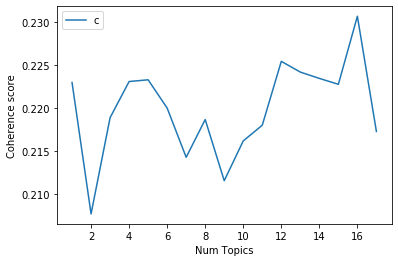

In [12]:
limit=18; start=1
x=range(start, limit)
plt.plot(x, coherence_values)
plt.xlabel('Num Topics')
plt.ylabel('Coherence score')
plt.legend('coherence_values', loc='best')
plt.show()

In [13]:
pprint(coherence_values)
index, value = max(enumerate(coherence_values), key=operator.itemgetter(1))
num_topics = len(coherence_values[:index+1])
print(index, value)

[0.22295741197514954,
 0.20770720921551333,
 0.218877245480556,
 0.22307455746328697,
 0.22327287331719575,
 0.2199914902420965,
 0.21427888369162165,
 0.21865812959512676,
 0.21156346166692916,
 0.2161795738387211,
 0.2180030065967074,
 0.22541361880977231,
 0.22416767821510797,
 0.22343576027070775,
 0.2227484685983888,
 0.2306490029084587,
 0.21727533629772405]
15 0.2306490029084587


In [14]:
topic_range = [5] # value determined by the above elbow plot 

    
alpha = list(np.arange(0.01, 1, 0.3)) + [50/x  for x in topic_range]
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
    
num_of_docs = len(corpus)
corpus_sets = [corpus]
    
corpus_title = ['100% Corpus']
    
model_results = {'Validation_set': [],
                    'Topics':[],
                    'Alpha':[],
                 'Beta':[],
                    'Coherence':[]}
models=[]
    
if 1 ==1:
    pbar = tqdm(total=len(topic_range) * len(alpha) * len(beta) * len(corpus_sets))
    
    for i in range(len(corpus_sets)):
        for k in topic_range:
            for a in alpha:
                for b in beta:
                    
                    model, cv = compute_coherence_values(corpus=corpus_sets[i],
                                                  dictionary=all_responses,
                                                     texts=texts,
                                                  k=k,
                                                  a=a,
                                                        b=b)
                    model_results['validation_set'].append(corpus_title[i])
                    model_results['topics'].append(k)
                    model_results['alpha'].append(a)
                    model_results['beta'].append(b)
                    model_results['coherence'].append(cv)
                    models.append(model)
                    
                    pbar.update(1)
    #pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()

In [15]:
# models = pickle.load( open( 'models_final.pkl', 'rb' ) )
# model_results = pickle.load(open('model_results_final.pkl','rb'))

In [16]:
lda_tuning = pd.DataFrame(model_results)
lda_tuning.head()

,Validation_set,Topics,Alpha,Beta,Coherence
0,100% Corpus,5,0.01,0.01,0.256973
1,100% Corpus,5,0.01,0.31,0.263339
2,100% Corpus,5,0.01,0.61,0.322353
3,100% Corpus,5,0.01,0.91,0.391111
4,100% Corpus,5,0.01,symmetric,0.251170


In [17]:
idx =lda_tuning['coherence'].idxmax(axis=0)
lda_tuning.iloc[idx]

Validation_set    100% Corpus
Topics                      5
Alpha                    0.91
Beta                     0.91
Coherence            0.430263
Name: 18, dtype: object

In [18]:
pprint(models[idx].print_topics(num_words=15))

[(0,
  '0.004*"education" + 0.004*"college" + 0.004*"teacher" + 0.003*"worker" + '
  '0.003*"wealth" + 0.002*"house" + 0.002*"today" + 0.002*"pay" + '
  '0.002*"union" + 0.002*"believe" + 0.002*"student_loan_debt" + '
  '0.002*"billionaires" + 0.002*"tax" + 0.002*"plan" + 0.002*"investment"'),
 (1,
  '0.010*"world" + 0.004*"ally" + 0.004*"climate_change" + 0.004*"war" + '
  '0.004*"foreign_policy" + 0.003*"United" + 0.003*"military" + '
  '0.003*"Afghanistan" + 0.002*"bring" + 0.002*"troop" + 0.002*"Russia" + '
  '0.002*"rebuild" + 0.002*"Trump" + 0.002*"great" + 0.002*"Syria"'),
 (2,
  '0.009*"work" + 0.006*"believe" + 0.005*"issue" + 0.005*"United" + '
  '0.004*"Donald_Trump" + 0.004*"run" + 0.004*"bring" + 0.004*"live" + '
  '0.004*"tell" + 0.004*"vote" + 0.004*"actually" + 0.004*"woman" + '
  '0.004*"change" + 0.004*"happen" + 0.004*"start"'),
 (3,
  '0.007*"China" + 0.003*"win" + 0.003*"trade" + 0.003*"datum" + '
  '0.003*"Donald_Trump" + 0.002*"table" + 0.002*"use" + 0.002*"borde

In [19]:

vis = pyLDAvis.gensim.prepare(models[idx], corpus, all_responses)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.130837  0.003042       1        1  54.640663
4      0.024126 -0.077721       2        1  14.629370
1      0.025212  0.051858       3        1  13.780646
0      0.039758 -0.006607       4        1   8.862389
3      0.041741  0.029429       5        1   8.086935, topic_info=     Category        Freq         Term       Total  loglift  logprob
63    Default  127.000000         plan  127.000000  30.0000  30.0000
60    Default   94.000000          pay   94.000000  29.0000  29.0000
326   Default   66.000000        world   66.000000  28.0000  28.0000
480   Default   53.000000     Medicare   53.000000  27.0000  27.0000
268   Default   67.000000  health_care   67.000000  26.0000  26.0000
...       ...         ...          ...         ...      ...      ...
1156   Topic5    4.115703        write   26.606220   0.6486  -6.7400
44     Topic5    3.548113      concern   15.660127   1.0302  -6.8884
1468   Topic5    3.446184    coalition   15.704762   0.9982  -6.9176
1441   Topic5    3.621397         beat   37.751881   0.1707  -6.8680
50     Topic5    3.685759      economy   60.126534  -0.2771  -6.8503

[290 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
30        1  0.271043      $
30        2  0.566727      $
30        3  0.049281      $
30        4  0.073921      $
30        5  0.049281      $
...     ...       ...    ...
1156      1  0.714119  write
1156      2  0.075170  write
1156      3  0.037585  write
1156      4  0.037585  write
1156      5  0.150341  write

[861 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 2, 1, 4])

In [20]:

# with open('model_results_final.pkl', 'wb') as f:
#     pickle.dump(model_results, f)
    
# with open('models_final.pkl', 'wb') as f:
#     pickle.dump(models, f)

In [21]:
#models = pickle.load( open( 'models_final.pkl', 'rb' ) )
#model_results = pickle.load(open('model_results_final.pkl','rb'))

In [22]:

response_topic = {}


for response in range(len(corpus)): # for each response/document in corpus
    re_bow = corpus[response]        #obtain the bow for the response
    res_topics = models[idx].get_document_topics(re_bow, 0) #obtain the topics mentioned in the response
    tmp = []
    for topic_id, topic_prob in res_topics: #obtain the topic id and topic probability for each topic in the response
        tmp.append(topic_prob)
    response_topic[key[response]]=tmp #assign the topic

In [23]:
topics_df = pd.DataFrame.from_dict(response_topic, orient='index')

candidates_response = [x.split(' ')[0] if x.split(' ')[1][0] in ['F','S','T'] else ' '.join(x.split(' ')[:2]) for x in topics_df.index]

In [24]:
topics_response = topics_df
topics_response['candidate'] = pd.Series(candidates_response, index=topics_df.index)
topic_col_names = ['topic_'+str(i) for i in range(5)]
topic_col_names.append('candidate')
topics_response.columns = topic_col_names

In [25]:
topics_response.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,candidate
Warren First Debate 2,0.046914,0.054728,0.644959,0.036209,0.217189,Warren
Klobuchar First Debate 1,0.214081,0.019940,0.287326,0.023406,0.455248,Klobuchar
O'Rourke First Debate 1,0.223552,0.174959,0.228802,0.175852,0.196835,O'Rourke
O'Rourke First Debate 2,0.096928,0.034099,0.311176,0.044744,0.513053,O'Rourke
O'Rourke First Debate 3,0.128632,0.167593,0.361842,0.162221,0.179713,O'Rourke


# Clustering responses & candidates

## Visualizing individual responses by topic

In [26]:
from sklearn.manifold import TSNE
import colorsys

In [27]:
tsne = TSNE(n_components=2,
            init='pca', 
            random_state=5, 
            perplexity = 50,
            n_iter=5000,
            learning_rate=10).fit_transform(topics_response[['topic_'+str(i) for i in range(5)]])

candidate_clusters = pd.DataFrame(tsne)
candidate_clusters = candidate_clusters.set_index(topics_response.index)

In [28]:
#can this be moved up one spot?
candidate_clusters['candidate']=[x.split(' ')[0] if x.split(' ')[1][0] in ['F','S','T'] else ' '.join(x.split(' ')[:2]) for x in candidate_clusters.index]


In [29]:
candidates = topics_response.candidate.tolist()
unique_candidates = list(set(candidates))
N = len(unique_candidates)
HSV_tups = [(x*1.0/N, .9, .9) for x in range(N)]
RGB_tups = map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tups)

cand_colors = {}
for c, i in zip(unique_candidates, RGB_tups):
    cand_colors[c] = i

In [30]:
#adjust and save the csv
topics_response['response_n']=list(range(1,len(corpus)+1))
topics_response.reset_index(drop=True,inplace=True )
#topics_response.to_csv('topics_by_response.csv',index=False)

In [31]:
debate_locs = debates.iloc[idxs][['date','debate']]
debate_locs['location'] = debates.apply(lambda x: x['debate'] +' '+ x['date'],axis=1)
debate_id = debate_locs.location.tolist()

candidate_clusters['debate_id'] = debate_id

In [32]:
unique_debates = list(set(debate_id))
N_d = len(unique_debates)

HSV_tups = [(x*1.0/N_d, .9, .9) for x in range(N)]
RGB_tups = map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tups)

debate_colors = {}
for c, i in zip(unique_debates, RGB_tups):
    debate_colors[c] = i

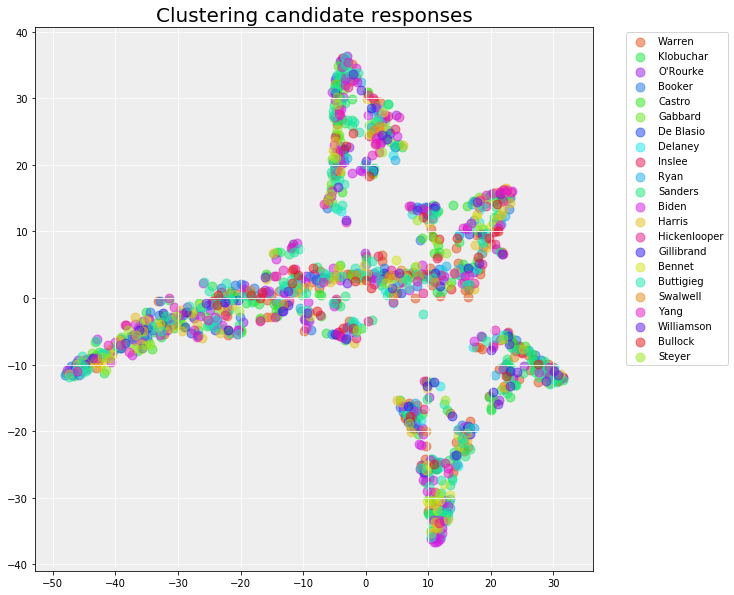

In [33]:
fig, ax = plt.subplots(subplot_kw=dict(facecolor='#EEEEEE'), figsize=(10,10))
ax.grid(color='white', linestyle='solid')

for c in candidate_clusters.candidate.unique():
    scatter = ax.scatter(candidate_clusters[candidate_clusters.candidate==c].loc[:,0].tolist(),
                    candidate_clusters[candidate_clusters.candidate==c].loc[:,1].tolist(),
                    s=80,
                    label=c,
                    alpha=.5,
                    c=np.array(cand_colors[c]).reshape(1,3))

ax.grid(color='white', linestyle='solid')
ax.set_title('Clustering candidate responses', size=20)
#labels=['<h3>{candidate}</h3>'.format(candidate=x) for x in candidates]
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()   

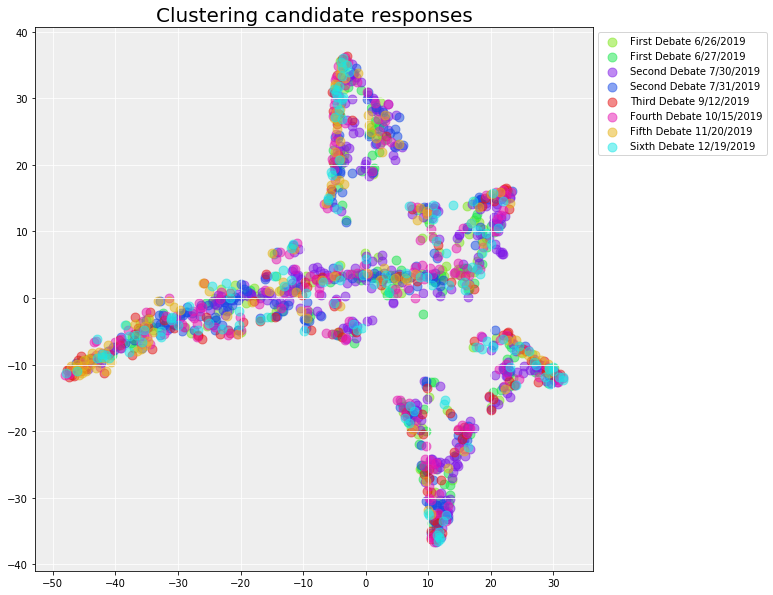

In [34]:
fig, ax = plt.subplots(subplot_kw=dict(facecolor='#EEEEEE'), figsize=(10,10))
ax.grid(color='white', linestyle='solid')

for d in candidate_clusters.debate_id.unique():
    scatter = ax.scatter(candidate_clusters[candidate_clusters.debate_id==d].iloc[:,0].tolist(),
                    candidate_clusters[candidate_clusters.debate_id==d].iloc[:,1].tolist(),
                    s=80,
                    label=d,
                    alpha=.5,
                    c=np.array(debate_colors[d]).reshape(1,3))

ax.grid(color='white', linestyle='solid')
ax.set_title('Clustering candidate responses', size=20)
#labels=['<h3>{candidate}</h3>'.format(candidate=x) for x in candidates]
plt.legend(bbox_to_anchor=(1.32, 1))
plt.show() 

In [35]:
candidate_clusters.reset_index(inplace=True)
candidate_clusters['debate'] = candidate_clusters.apply(lambda x: str(x['index']).split(' ')[1], axis=1)

In [36]:
candidate_clusters.drop(columns=['index'], inplace=True)

In [37]:
candidate_clusters.columns=['x','y','candidate','debate','debate_id']

In [38]:
#candidate_clusters.to_csv('tsne_cluster_by_response.csv', index=False)
display(candidate_clusters.head())

,x,y,candidate,debate,debate_id
0,-4.214964,-5.061900,Warren,First Debate 6/26/2019,First
1,12.964701,-16.813532,Klobuchar,First Debate 6/26/2019,First
2,17.287252,3.909438,O'Rourke,First Debate 6/26/2019,First
3,8.942237,-19.546318,O'Rourke,First Debate 6/26/2019,First
4,12.540996,3.351538,O'Rourke,First Debate 6/26/2019,First


## Visualizing candidates by the topics in their responses

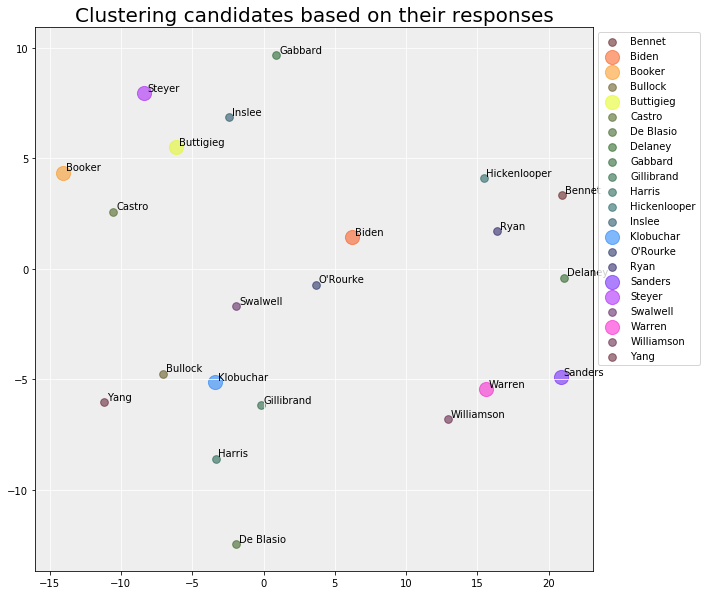

In [39]:
columns = ['topic_'+str(i) for i in range(5)]
df = topics_response.groupby('candidate')[columns].sum()
df = 100*df.div(df.sum(axis=1), axis=0)
df=np.round(df,1)

s_cluster_t = TSNE(n_components=2,
                   init='pca', 
                   random_state=5, 
                   perplexity = 5,
                   n_iter=5000,
                   early_exaggeration=1,
                   learning_rate=10.0).fit_transform(df)

s_cluster = pd.DataFrame(s_cluster_t)
s_cluster = s_cluster.set_index(df.index)

candidates_s = df.index.tolist()
N = len(candidates_s)
HSV_tups = [(x*1.0/N, .98, .98) for x in range(N)]
RGB_tups = map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tups)

cand_colors_s = {}
for c, i in zip(candidates_s, RGB_tups):
    cand_colors_s[c] = i
    
sizes = {}
for i in cand_colors_s.keys():
    if i.split(' ')[0].lower() in [x.split(' ')[0].lower() for x in withdrawn]:
        sizes[i] = 60
    else:
        sizes[i] = 200

for i in cand_colors_s.keys():
    if i.split(' ')[0].lower() in [x.split(' ')[0].lower() for x in withdrawn]:
        cand_colors_s[i] = tuple(map(lambda x: x/3.2, cand_colors_s[i]))

fig, ax = plt.subplots(subplot_kw=dict(facecolor='#EEEEEE'), figsize=(10,10))
ax.grid(color='white', linestyle='solid')

for c in candidates_s:
    scatter = ax.scatter(s_cluster.loc[c][0],
                    s_cluster.loc[c][1],
                    s=sizes[c],
                    label=c,
                    alpha=.5,
                    c=np.array(cand_colors_s[c]).reshape(1,3))
    label_point_orig(pd.Series(s_cluster.loc[c][0]),
                     pd.Series(s_cluster.loc[c][1]),
                     pd.Series(c),
                     ax)

ax.grid(color='white', linestyle='solid')
ax.set_title('Clustering candidates based on their responses', size=20)
plt.legend(bbox_to_anchor=(1, 1))
plt.show() 

In [40]:
s_cluster.reset_index(inplace=True)
s_cluster.columns=['candidate','x','y']

In [41]:
'''cluster candidates by an aggregate of all their response topics'''
#s_cluster.to_csv('tsne_cluster_by_candidate_rs.csv', index=False)
display(s_cluster.head())

,candidate,x,y
0,Bennet,20.930241,3.331145
1,Biden,6.202884,1.441334
2,Booker,-14.023370,4.348143
3,Bullock,-7.053224,-4.740155
4,Buttigieg,-6.141245,5.499999


# Visualizing candidates by the words in their responses

In [42]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import get_tmpfile

In [43]:
def tsne_plot(model, p=5, lr=10.0, ee=1):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for doc in model.docvecs.index2entity:
        tokens.append(model[doc])
        labels.append(doc)
    
    tsne_model = TSNE(perplexity=p,
                      n_components=2,
                      init='pca',
                      n_iter=5000,
                      learning_rate=lr,
                      random_state=5,
                     early_exaggeration=ee)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i], s=80)
        plt.annotate(labels[i],
                     xy=(x[i]-.1, y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
    
def tsne_plot_dict(data , p=5, lr=10.0, ee=1):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for doc, arr in data.items():
        tokens.append(arr)
        labels.append(doc)
    
    tsne_model = TSNE(perplexity=p,
                      n_components=2,
                      init='pca',
                      n_iter=5000,
                      learning_rate=lr,
                      random_state=5,
                     early_exaggeration=ee)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i], s=100)
        plt.annotate(labels[i],
                     xy=(x[i]-.15, y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
    
    new_values = pd.DataFrame(new_values, columns = ['x','y'])
    new_values.index=labels
    
    return new_values

In [44]:
#create TaggedDocuments for the Doc2Vec model using a list of responses and the candidate who said them as the tag
documents = [TaggedDocument(doc, [tag]) for tag, doc in zip(speakers, trim_responses)]

#creating two Doc2Vec models, a Distributed Memory (PV-DM) and a Distributed Bag of Words (PV-DBOW) model. 
dm_model=Doc2Vec(documents, dm=1, alpha=.025, vector_size=100, min_alpha=.025, min_count=0, seed=5, sorted_vocab=True)
dbow_model=Doc2Vec(documents, dm=0, alpha=.025, vector_size=100, min_alpha=.025, min_count=0, seed=5, sorted_vocab=True)

#training each model with the corpus in 20 epochs
for epoch in tqdm(range(20)):
    dm_model.train(documents, total_examples=dm_model.corpus_count, epochs =20)
    dm_model.alpha-=.002
    dm_model.min_alpha = dm_model.alpha

for epoch in tqdm(range(20)):
    dbow_model.train(documents, total_examples=dbow_model.corpus_count, epochs =20)
    dbow_model.alpha-=.002
    dbow_model.min_alpha = dbow_model.alpha
    
    


In [45]:
# fname = get_tmpfile('doc2vec_dm_model')
# dm_model.save(fname)
# dm_model=Doc2Vec.load(fname)

# fname = get_tmpfile('doc2vec_dbow_model')
# dbow_model.save(fname)
# dbow_model=Doc2Vec.load(fname)

In [46]:
#create a df/csv of all the candidates and their similarity to other candidates using both models' results
similarity_df = defaultdict(list)
for model in [dm_model, dbow_model]:
    n_cands = len(model.docvecs.index2entity)
    for candidate in model.docvecs.index2entity:
        for (o_candidate, sim) in model.docvecs.most_similar(candidate, topn=n_cands):
            similarity_df['candidate'].append(candidate)
            similarity_df['opp_candidate'].append(o_candidate)
            similarity_df['similarity'].append(sim)
            similarity_df['model'].append(str(model)[8:12])
        
similarity_df = pd.DataFrame(similarity_df)   

In [47]:
#similarity_df.to_csv('candidate_word_r_similarity.csv', index=False)
display(similarity_df.head())

,candidate,opp_candidate,similarity,model
0,Warren,Buttigieg,0.563639,dm/m
1,Warren,Klobuchar,0.501200,dm/m
2,Warren,Williamson,0.463844,dm/m
3,Warren,Hickenlooper,0.455636,dm/m
4,Warren,Delaney,0.455198,dm/m


In [48]:
# concat both  model arrays together. 'The combination of both models work consistently better'
#          https://cs.stanford.edu/~quocle/paragraph_vector.pdf
concat_arry={}

for candidate in dbow_model.docvecs.index2entity:
    concat_arry[candidate]=np.concatenate((dm_model[candidate], dbow_model[candidate]))

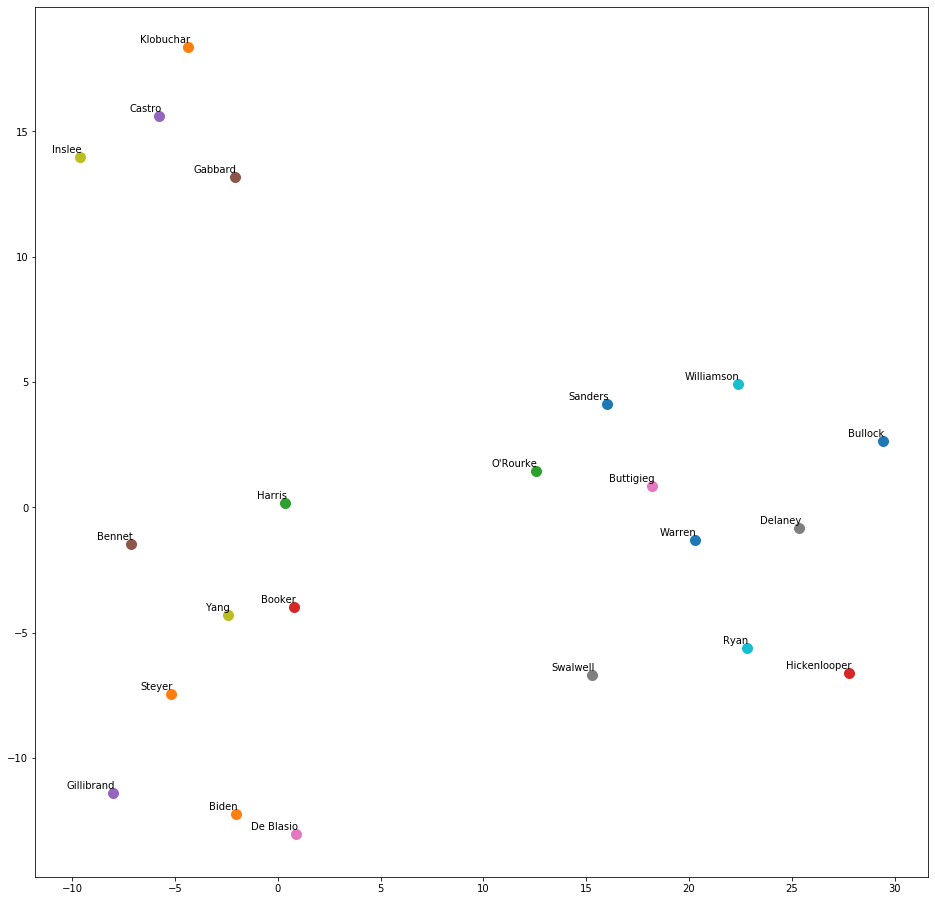

In [49]:
#plot the concatenated vector
tsne_points_df = tsne_plot_dict(concat_arry) 

In [50]:
#tsne_points_df.to_csv('tsne_vals_docvec.csv', index=False)
tsne_points_df.head()

,x,y
Warren,20.275768,-1.299953
Klobuchar,-4.345072,18.382185
O'Rourke,12.551414,1.462108
Booker,0.790964,-3.958816
Castro,-5.753026,15.631330


# Debate topics by Response

In [51]:
def format_topics_sentences(lda_model, corpus=corpus, texts=texts, speakers=speakers):
    
    sent_topics_df = pd.DataFrame()
    
    for i, row in enumerate(lda_model[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:
                wp = lda_model.show_topic(topic_num)
                topic_keywords = ', '.join([word for word,prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['dominant_topic','perc_contribution','topic_keywords']
    
    contents = pd.Series(texts)
    speakers = pd.Series(speakers)
    sent_topics_df = pd.concat([sent_topics_df, contents, speakers],axis=1)
    return(sent_topics_df)



### Find the dominant topic in each sentence

In [52]:
df_topic_sents_keywords = format_topics_sentences(models[33], corpus, trim_responses, speakers)

df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns=['document_no','dominant_topic','topic_perc_contrib', 'keywords','text','candidate']


In [53]:
'''display the the dominant dopic & perc contribution for each response'''
#df_dominant_topic.to_csv('dominant_topic_per_response.csv', index=False)
display(df_dominant_topic.head())

,document_no,dominant_topic,topic_perc_contrib,keywords,text,candidate
0,0,0.0,0.9817,"work, plan, pay, believe, family, health_care,...",So I think of it this way. Who is this economy...,Warren
1,1,0.0,0.9878,"work, plan, pay, believe, family, health_care,...","Well, first, the economy. We know that not eve...",Klobuchar
2,2,0.0,0.6651,"work, plan, pay, believe, family, health_care,...",This economy has got to work for everyone. And...,O'Rourke
3,3,0.0,0.9822,"work, plan, pay, believe, family, health_care,...","Right now, we have a system that favors those ...",O'Rourke
4,4,0.0,0.8650,"work, plan, pay, believe, family, health_care,...",That's how we each have a voice in our democra...,O'Rourke


## Find the most representative response for each topic

In [54]:
res_topics_sorted_btopic=pd.DataFrame()
topic_sents_grpd = df_topic_sents_keywords.groupby('dominant_topic')
for i, grp in topic_sents_grpd:
    res_topics_sorted_btopic=pd.concat([res_topics_sorted_btopic,grp.sort_values(['perc_contribution'],
                                                                                 ascending=[0]).head(5)],
                                       axis=0)

res_topics_sorted_btopic.reset_index(drop=True, inplace=True)
res_topics_sorted_btopic.columns=['topic_num','topic_perc_contrib','keywords','text','candidate']

In [55]:
'''Top 5 contributing responses per topic'''
#res_topics_sorted_btopic.to_csv('top_topics_responses.csv', index=False)
display(res_topics_sorted_btopic.head())

,topic_num,topic_perc_contrib,keywords,text,candidate
0,0.0,0.9945,"work, plan, pay, believe, family, health_care,...","And thank you, George, to Jorge, to Linsey, a...",Castro
1,0.0,0.9934,"work, plan, pay, believe, family, health_care,...",Thank you. My challenges and resilience have ...,Klobuchar
2,0.0,0.9934,"work, plan, pay, believe, family, health_care,...","First, I want to thank all the voters tuned i...",Yang
3,0.0,0.9930,"work, plan, pay, believe, family, health_care,...",The nation was riveted this week by the testi...,Klobuchar
4,0.0,0.9929,"work, plan, pay, believe, family, health_care,...","Thank you, Rachel. It's an honor to be here t...",Booker


## Find the 5 most representative responses for each topic

In [56]:
topic_text_df = defaultdict(list)

for topic in sorted(df_dominant_topic.dominant_topic.unique()):
    for candidate in df_dominant_topic.candidate.unique():
        for rating, text in enumerate(df_dominant_topic[(df_dominant_topic.dominant_topic==topic)&(df_dominant_topic.candidate==candidate)].sort_values('topic_perc_contrib', ascending=False).text[:6].tolist()):
            topic_text_df['candidate'].append(candidate)
            topic_text_df['topic'].append(topic)
            topic_text_df['text'].append(text)
            topic_text_df['rating'].append(rating+1)
topic_text_df = pd.DataFrame.from_dict(topic_text_df)

In [57]:
'''Top 5 contributing responses per topic by  candidate'''
#topic_text_df.to_csv('top_topics_by_candidate.csv', index=False)
display(topic_text_df.head())

,candidate,topic,text,rating
0,Warren,0.0,"So, thank you. You know, I've listened to thi...",1
1,Warren,0.0,"I mentioned earlier, I've known what I wanted...",2
2,Warren,0.0,Yes. Think of it this way. Our housing proble...,3
3,Warren,0.0,"So, as I've talked about before, I have a two...",4
4,Warren,0.0,So I think the way we achieve our goals and b...,5
